# Collaborative Filtering Recommendation System

This notebook implements a **collaborative filtering recommendation system** using a deep learning-based **autoencoder** model. The system analyzes customer purchase behavior and learns latent factors to recommend products based on the interactions previously.

Key aspects covered in this notebook:
- Building a sparse customer-item matrix from **transactions_train.csv**.
- Training an autoencoder to learn embeddings for customers and products.
- Predicting and recommending products to customers based on learned patterns.
- Building an interactive **UI using Gradio**, a popular Python library:
  - The UI takes a **customer ID** as input.
  - Displays the products that the customer has purchased previously.
  - Provides personalized product recommendations within the interface.

### **Deployment**
The interactive recommendation system is deployed on **Hugging Face Spaces** and is live at the following URL:  
[https://huggingface.co/spaces/Rishi3499/DataMining](https://huggingface.co/spaces/Rishi3499/DataMining)

The combination of collaborative filtering and a user-friendly interface ensures an engaging and personalized shopping experience.



In [622]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
import seaborn as sns
import os.path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model
import plotly.express as px

%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

In [639]:
# Load transaction data frame
transactions = pd.read_csv("transactions_train.csv")
transactions = transactions.head(2000)
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [532]:
transactions['bought'] = 1 #the interaction matrix will be binary
df=transactions[['customer_id', 'article_id', 'bought']]
df.head()

,customer_id,article_id,bought
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,1
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,1
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,1
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,1
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,1


In [534]:
df = df.drop_duplicates()

In [536]:
# Creating a sparse pivot table with customers in rows and items in columns
customer_items_matrix_df = df.pivot(index   = 'customer_id', 
                                    columns = 'article_id', 
                                    values  = 'bought').fillna(0)
customer_items_matrix_df.head(10)

article_id,108775015,110065001,111593001,153115039,156231001,156231002,160442007,176550020,179208001,179950001,...,713997001,714373001,714417001,714425001,716519001,719017002,720384002,725253001,728162001,728162002
customer_id,,,,,,,,,,,,,,,,,,,,,
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001127bffdda108579e6cb16080440e89bf1250a776c6e55f56e35e9ee029a8d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001ea4e9c54f7e9c88811260d954edc059d596147e1cf8adc73323aebf571fd8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001fd23db1109a94bba1319bb73df0b479059027c182da490e1161b34cd3af61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0021da829b898f82269fc51feded4eac2129058ee95bd75bb1591e2eb14ecc79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [538]:
customer_items_matrix_df.shape

(599, 1496)

In [540]:
customer_items_matrix_df_train, customer_items_matrix_df_test = train_test_split(customer_items_matrix_df,test_size=0.33, random_state=42)
print(customer_items_matrix_df_train.shape, customer_items_matrix_df_test.shape)

(401, 1496) (198, 1496)


In [542]:
how_sparse = customer_items_matrix_df_train.values.mean()*100

print("We have only", how_sparse, "percent of the values filled in the sparse matrix.")

We have only 0.20520223505407606 percent of the values filled in the sparse matrix.


In [544]:
def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model




In [546]:
# We want to map the input to itself
X = customer_items_matrix_df_train.values

# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(learning_rate=0.0001), loss='mse')
    
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ UserScore (InputLayer)               │ (None, 1496)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ EncLayer1 (Dense)                    │ (None, 512)                 │         766,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LatentSpace (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DecLayer1 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ UserScorePred (Dense)                │ (None, 1496)                │         767,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,796,824 (6.85 MB)

 Trainable params: 1,796,824 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [548]:
hist = model.fit(x=X, y=X,
                  epochs=60,# Using 50 here instead of 10 or 20 improved the performance very much!
                  batch_size=16,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0404 - val_loss: 0.0112
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368 - val_loss: 0.0102
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0296 - val_loss: 0.0094
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - val_loss: 0.0088
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0241 - val_loss: 0.0083
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0220 - val_loss: 0.0078
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0186 - val_loss: 0.0074
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0185 - val_loss: 0.0071
Epoch 9/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0164 - val_loss: 0.0068
Epoch 10/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0155 - val_loss: 0.0065
Epoch 11/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 12/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

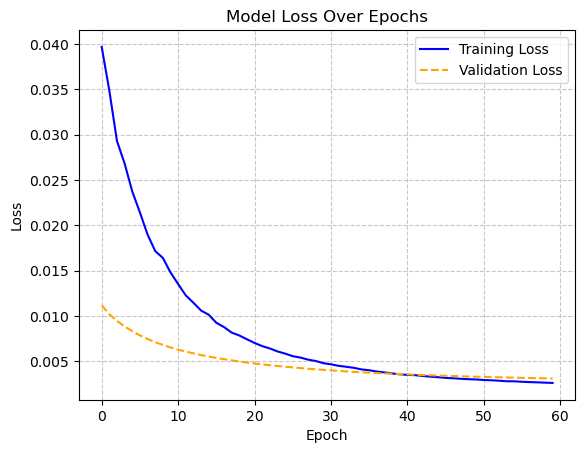

In [550]:
def plot_hist(hist):
    # Create figure & 1 axis
    fig, ax = plt.subplots()

    # Plot training loss
    ax.plot(hist.history['loss'], label='Training Loss', color='blue', linestyle='-')

    # Plot validation loss
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

    # Set plot title and labels
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

# Assuming 'hist' is the history object from model.fit
plot_hist(hist)


In [552]:
# Predict new Matrix Interactions, set score zero on articles customer haven't purchased
new_matrix = model.predict(X) * (X[0] == 0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [630]:
# converting the reconstructed matrix back to a Pandas dataframe
new_customer_items_matrix_df  = pd.DataFrame(new_matrix, 
                                            columns = customer_items_matrix_df_train.columns, 
                                            index   = customer_items_matrix_df_train.index)
new_customer_items_matrix_df.tail(200)

article_id,108775015,110065001,111593001,153115039,156231001,156231002,160442007,176550020,179208001,179950001,...,713997001,714373001,714417001,714425001,716519001,719017002,720384002,725253001,728162001,728162002
customer_id,,,,,,,,,,,,,,,,,,,,,
08d5c6f7f8b3583393e8551cf5443132468a0b482c38e6b26996172a722426cb,-0.006631,-0.006530,-0.008768,-0.002972,0.007802,0.010167,-0.005645,0.010328,0.007077,0.005824,...,0.003903,0.001800,-0.015364,0.005872,-0.003086,0.012353,-0.003008,-0.008586,0.004946,0.005689
08834cc37fb79321ba4c7adf643d452faa7d287694a048879ed5a616b76e318a,-0.008405,-0.000478,0.010936,0.007558,-0.005887,0.000555,-0.007730,0.004114,0.008765,0.010958,...,-0.000367,0.005480,0.006631,0.005080,0.001683,-0.004017,0.008934,-0.003632,0.003968,-0.003723
0755f30a2c22a8a10c3453757f69f502e221e817181c8179153f86fb75cd183e,0.018585,0.004370,-0.008486,-0.006960,-0.018394,-0.018422,0.011300,0.010472,0.027214,-0.016965,...,-0.010498,0.026432,-0.008236,0.019298,0.014617,0.016447,-0.003230,-0.011029,-0.008673,0.012350
01ff82d2792db8d2f92caa1e934fd6a122117f99a47f500ed25e550b7e066362,0.007007,0.002585,0.014129,0.025617,-0.019440,0.006005,-0.003332,0.013850,-0.003736,-0.006028,...,0.002504,0.005872,-0.008105,-0.000983,0.005282,-0.001674,-0.003399,0.000752,0.000170,-0.000232
03126e45c08e82cd192b32cbddbeba63387e11e5531059d1e75b74a422f373b1,0.014507,-0.024486,-0.004157,0.005345,-0.019127,0.015900,-0.020699,0.016073,-0.010050,0.026273,...,-0.003392,-0.023201,-0.022827,0.007077,-0.011294,-0.005274,-0.002326,-0.008724,0.013913,0.005220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
013d1d9e3414787ec7bf048697592b6f76dec3bd5263e485e64429ce387ed09c,0.017792,0.133249,-0.042232,-0.034604,-0.007951,0.035342,-0.012936,-0.004123,-0.001586,-0.041841,...,-0.016924,0.056533,0.002502,0.010330,0.017403,0.003329,-0.053552,-0.007906,-0.059407,-0.028490
01ef5256e6264e9d50b11a08e9cfb2f2291324fedb4140cf7b4ad070548ffd8f,0.043514,-0.049052,0.040418,0.017957,0.049088,0.042918,-0.005469,0.074476,0.038950,-0.022022,...,-0.140687,0.029769,0.028886,-0.012568,0.014293,-0.032221,0.026547,0.019765,0.036229,0.017870
04f4e99383e71a1f72cd6d7c87ef771631e0dfd2998217de0273266cbc081f8c,0.031524,0.002803,-0.014365,0.008688,0.007785,-0.012962,0.042541,0.014001,-0.004517,-0.001303,...,0.002220,0.014891,0.013260,0.007985,0.024010,0.032181,-0.013659,0.009487,0.005500,0.003166


In [556]:
print(new_customer_items_matrix_df.values.min(), new_customer_items_matrix_df.values.max())

-0.21743695 0.24503174


In [558]:
def recommender_for_customer(customer_id, interact_matrix, df_content, topn = 5):
    '''
    Recommender Articles for Customers
    '''
    pred_scores = interact_matrix.loc[customer_id].values

    df_scores   = pd.DataFrame({'article_id': list(customer_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('article_id')\
                    .join(df_content.set_index('article_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'prod_name']]
    
    return df_rec[df_rec.score > 0]

In [604]:
articles = pd.read_csv("articles.csv")

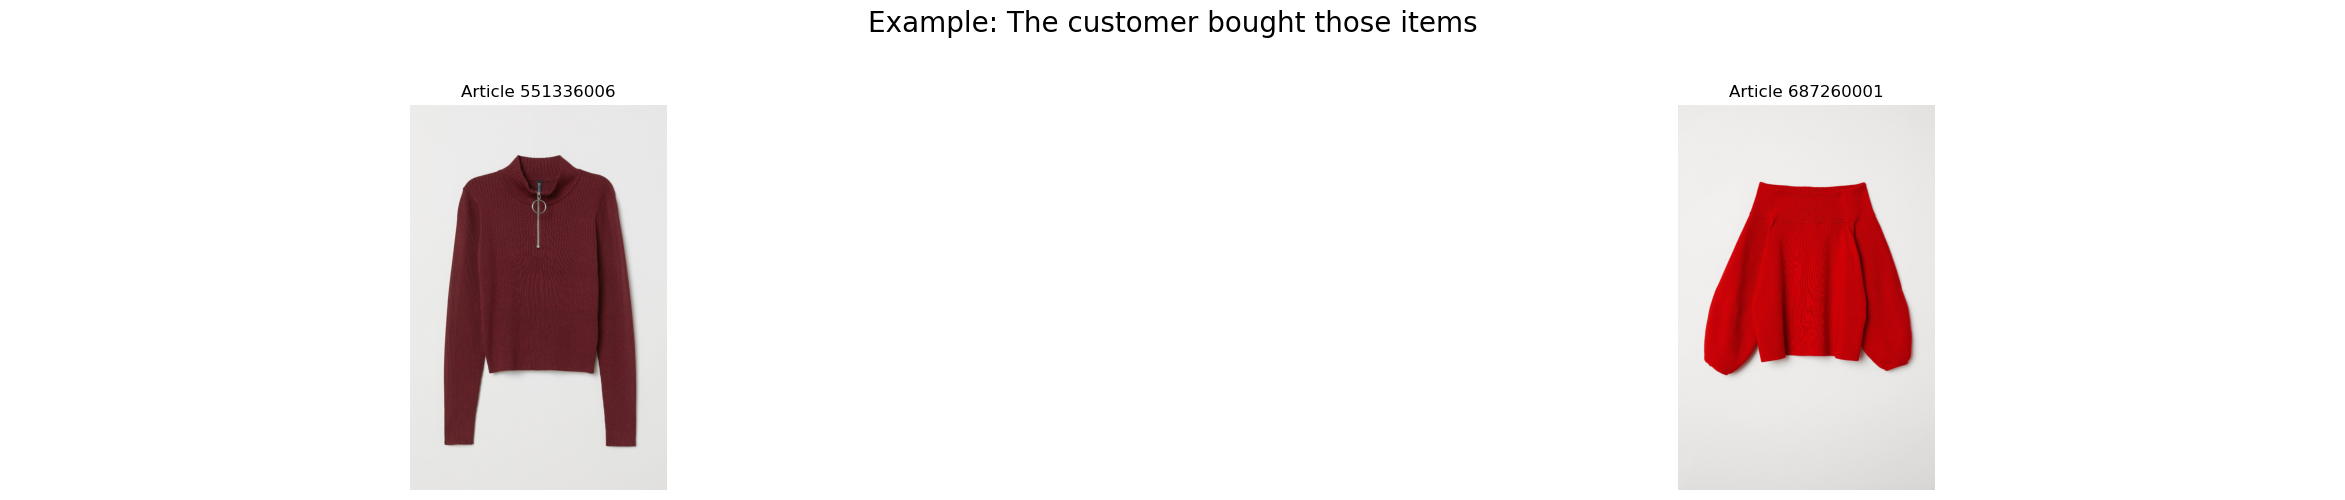

In [123]:
# EXAMPLE: ARTICLE previously purchased by the customer
hist_customer=recommender_for_customer(customer_id     = '08ef984221fd7b8d9d903c991eec3cda5a3af7a82882c82dc9030c4d536a137c', 
                         interact_matrix = customer_items_matrix_df, 
                         df_content      = articles)


prev_items = hist_customer.index.values
k=len(prev_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: The customer bought those items\n\n',size=20)
plt.axis('off')

for item, i in zip(prev_items, range(1, k+1)):
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()

In [125]:
#EXAMPLE: SEE THE LIST OF ARTICLES previously purchased by the customer
hist_customer

,score,prod_name
article_id,,
551336006,1.0,Yolo Zip L/S
687260001,1.0,Prince Charles (1)


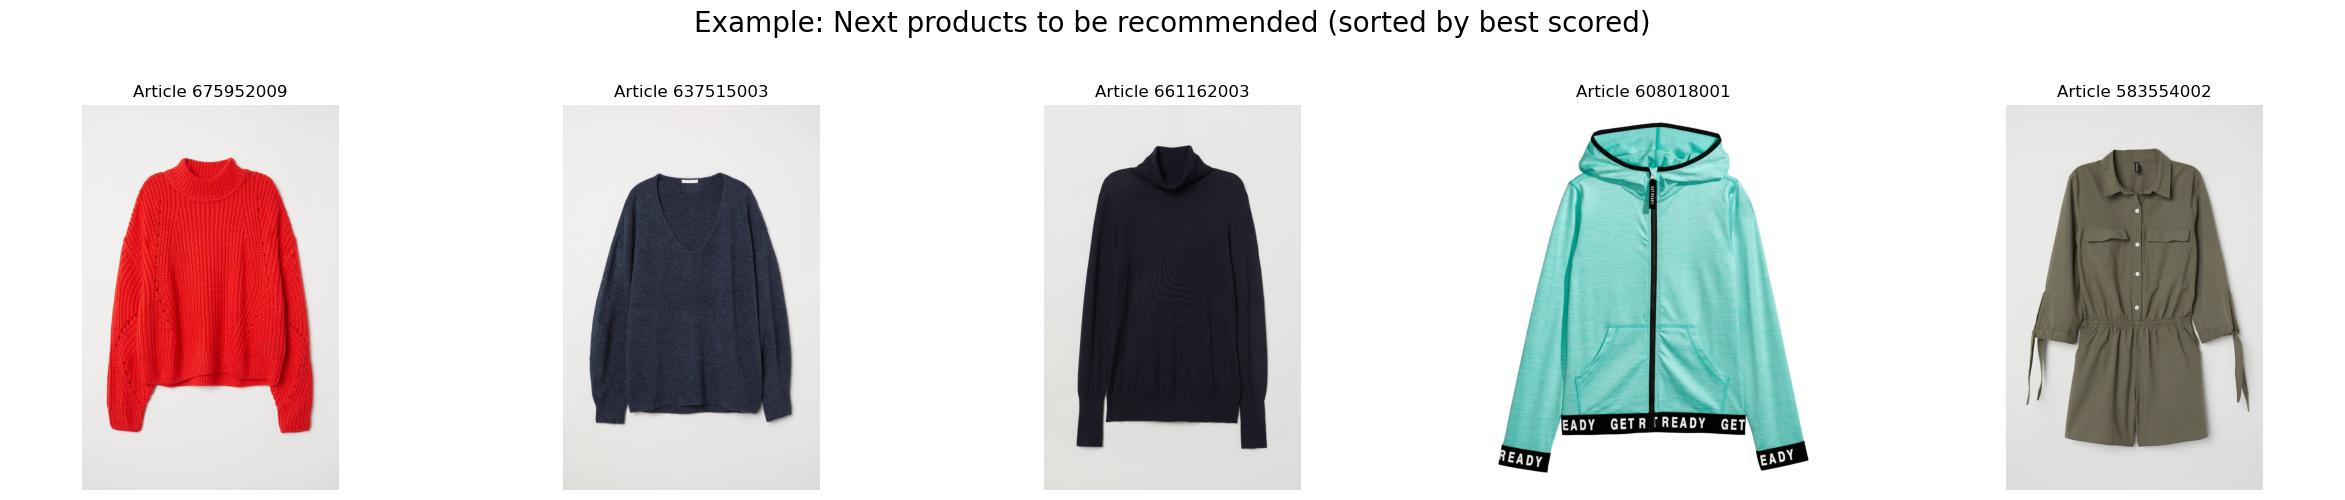

In [127]:
#EXAMPLE: Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec=recommender_for_customer(customer_id     = '08ef984221fd7b8d9d903c991eec3cda5a3af7a82882c82dc9030c4d536a137c', 
                         interact_matrix = new_customer_items_matrix_df, 
                         df_content      = articles)

next_items = hist_customer_rec.index.values
k=len(next_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: Next products to be recommended (sorted by best scored)\n\n',size=20)
plt.axis('off')

for item, i in zip(next_items, range(1, k+1)):
    
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)    
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()
    

In [129]:
#EXAMPLE: SEE THE LIST OF Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec

,score,prod_name
article_id,,
675952009,0.078951,Portland
637515003,0.074535,Matey
661162003,0.072573,Teddy
608018001,0.071950,MOLLY HOOD Fancy
583554002,0.071783,Lucky utility jumpsuit


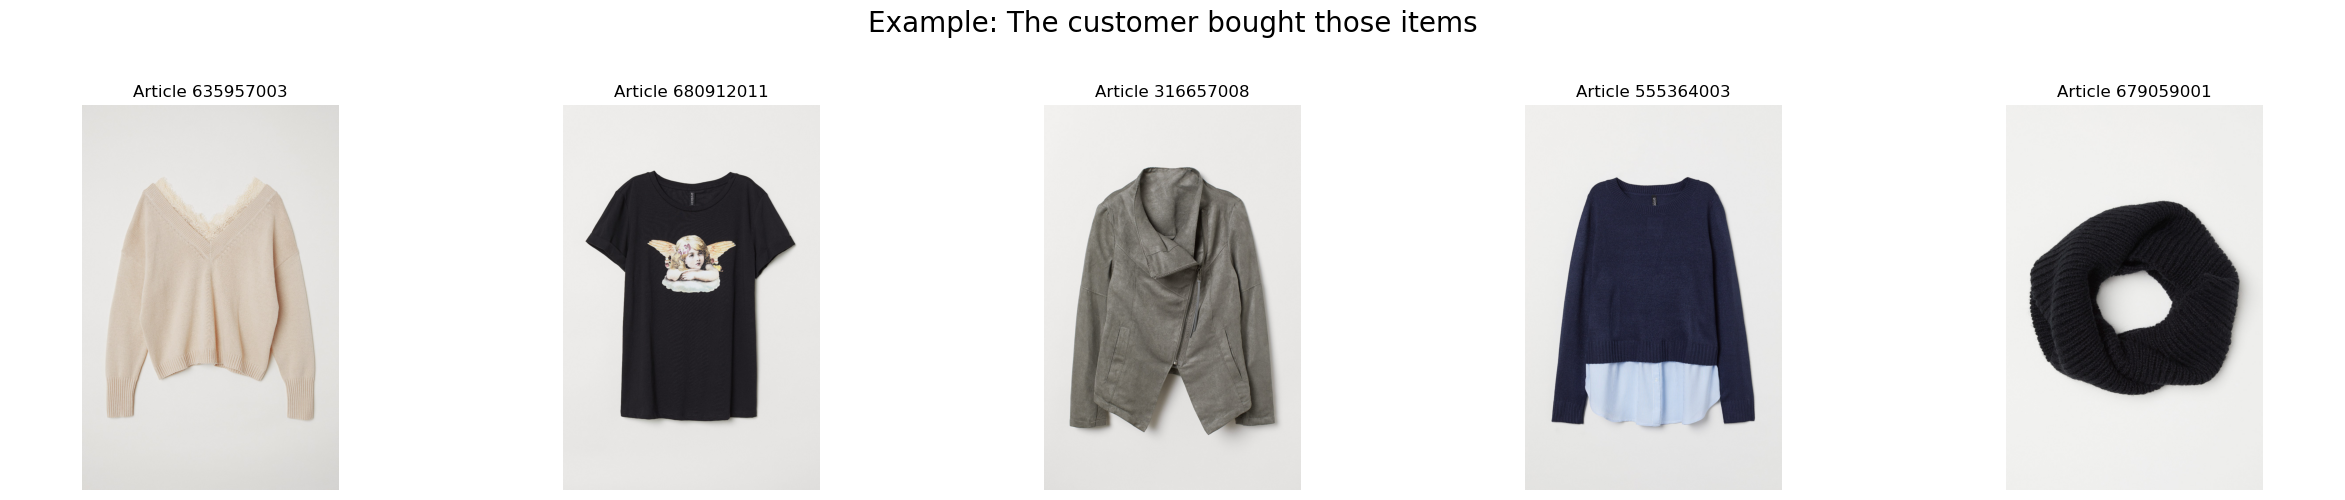

In [308]:
# EXAMPLE: ARTICLE previously purchased by the customer
hist_customer=recommender_for_customer(customer_id     = '02e0910945216963833093e0e56712e7362b01b7ef0cd4b375f857542b085020', 
                         interact_matrix = customer_items_matrix_df, 
                         df_content      = articles)


prev_items = hist_customer.index.values
k=len(prev_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: The customer bought those items\n\n',size=20)
plt.axis('off')

for item, i in zip(prev_items, range(1, k+1)):
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()

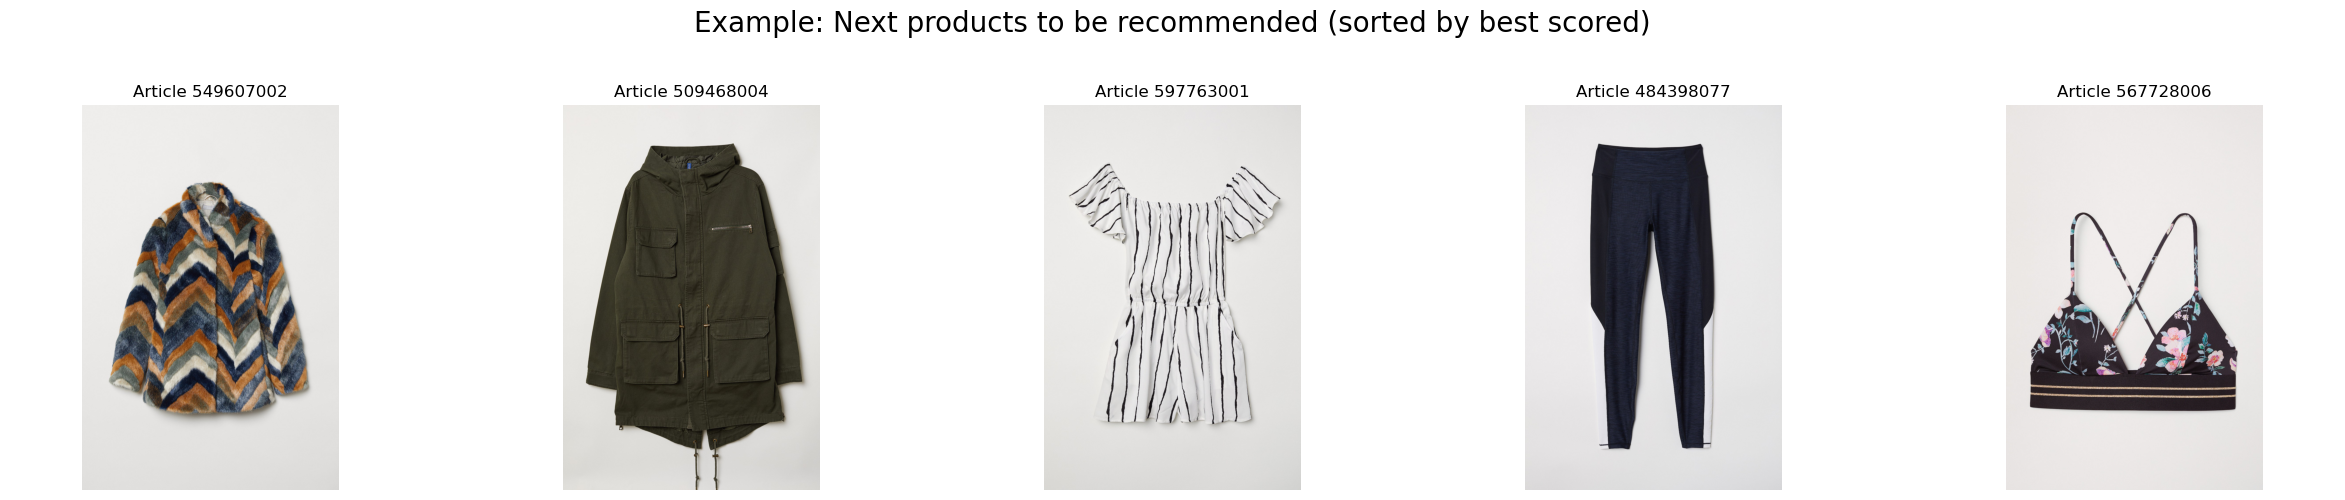

In [522]:
#EXAMPLE: Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec=recommender_for_customer(customer_id     = '02e0910945216963833093e0e56712e7362b01b7ef0cd4b375f857542b085020', 
                         interact_matrix = new_customer_items_matrix_df, 
                         df_content      = articles)

next_items = hist_customer_rec.index.values
k=len(next_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: Next products to be recommended (sorted by best scored)\n\n',size=20)
plt.axis('off')

for item, i in zip(next_items, range(1, k+1)):
    
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)    
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()
    

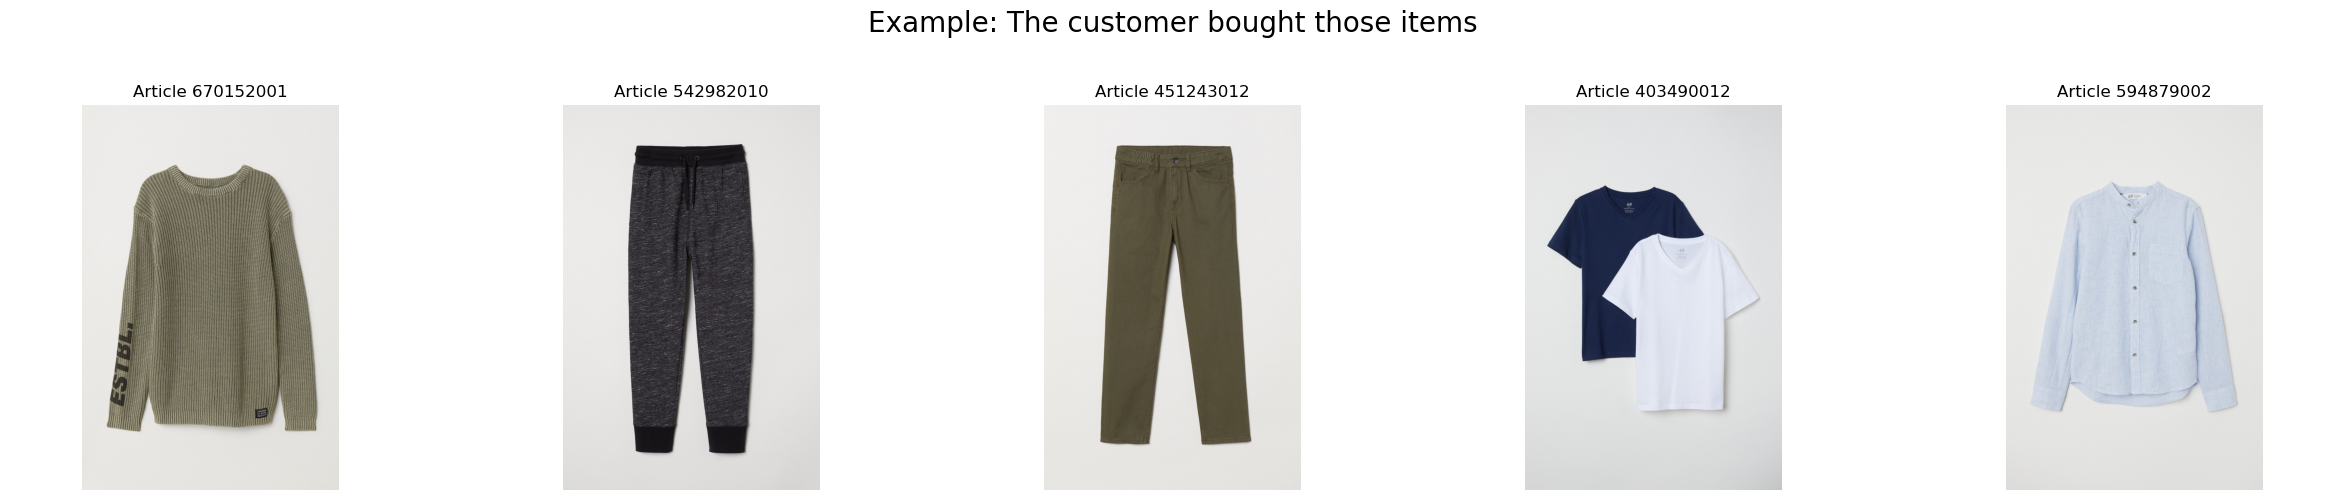

In [524]:
# EXAMPLE: ARTICLE previously purchased by the customer
hist_customer=recommender_for_customer(customer_id     = '07b9c65c7f3f1b709c9163bcecf62ac438a5ab5e9b6e13214667e7229bc4294a', 
                         interact_matrix = customer_items_matrix_df, 
                         df_content      = articles)


prev_items = hist_customer.index.values
k=len(prev_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: The customer bought those items\n\n',size=20)
plt.axis('off')

for item, i in zip(prev_items, range(1, k+1)):
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()

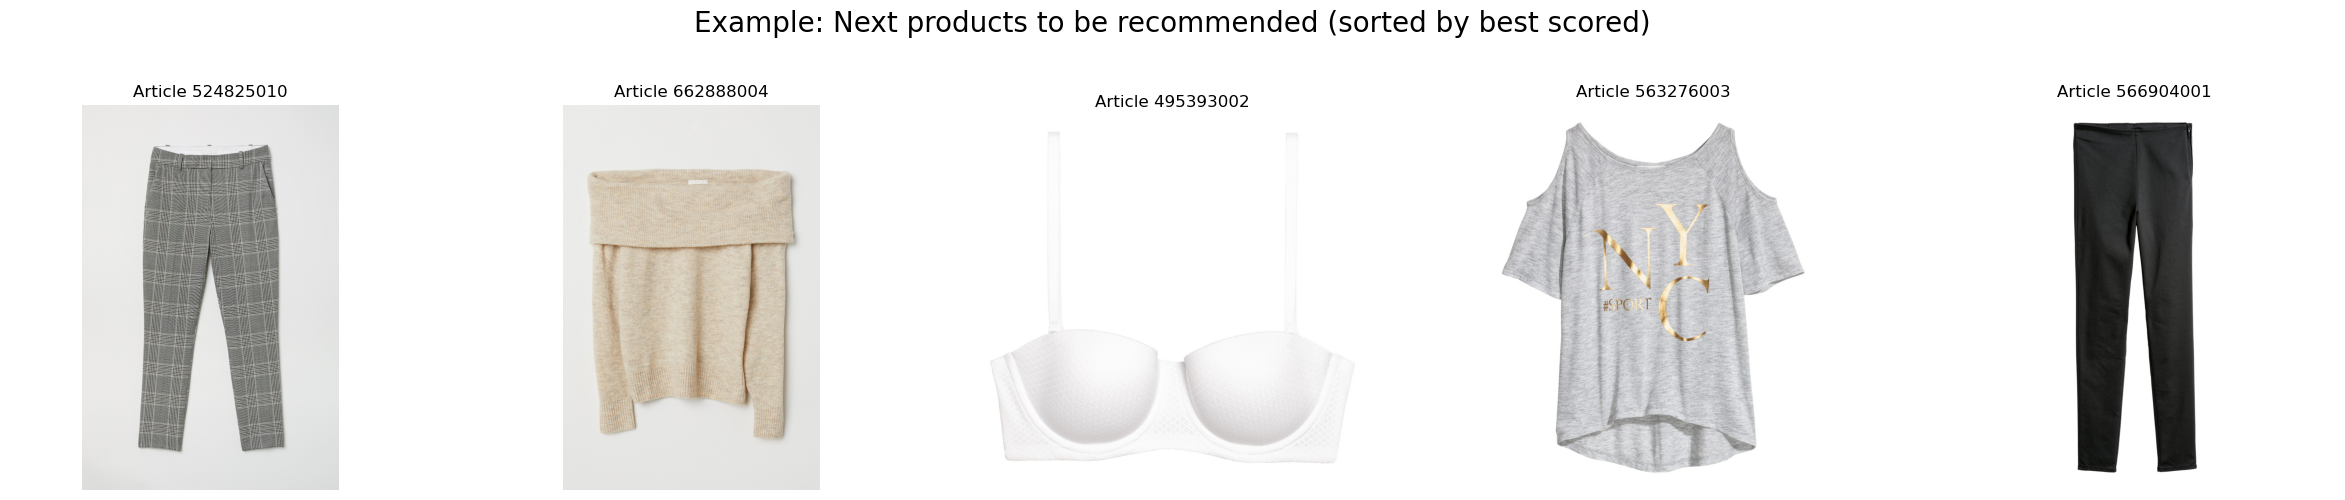

In [526]:
#EXAMPLE: Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec=recommender_for_customer(customer_id     = '07b9c65c7f3f1b709c9163bcecf62ac438a5ab5e9b6e13214667e7229bc4294a', 
                         interact_matrix = new_customer_items_matrix_df, 
                         df_content      = articles)

next_items = hist_customer_rec.index.values
k=len(next_items)
plt.close('all')
fig = plt.figure(figsize=(30, 5))

plt.title('Example: Next products to be recommended (sorted by best scored)\n\n',size=20)
plt.axis('off')

for item, i in zip(next_items, range(1, k+1)):
    
    article_id = str(item)
    path = "images1/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)    
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)
plt.show()

In [ ]:
# Here starts my testing

In [562]:
!pip install gradio

   ---------------------------------------- 0.0/57.1 MB ? eta -:--:--
    --------------------------------------- 1.0/57.1 MB 5.6 MB/s eta 0:00:11
   - -------------------------------------- 2.6/57.1 MB 6.6 MB/s eta 0:00:09
   --- ------------------------------------ 4.5/57.1 MB 7.3 MB/s eta 0:00:08
   ---- ----------------------------------- 6.3/57.1 MB 7.6 MB/s eta 0:00:07
   ----- ---------------------------------- 7.9/57.1 MB 7.7 MB/s eta 0:00:07
   ------ --------------------------------- 9.7/57.1 MB 7.7 MB/s eta 0:00:07
   ------- -------------------------------- 11.3/57.1 MB 7.7 MB/s eta 0:00:06
   --------- ------------------------------ 13.1/57.1 MB 7.8 MB/s eta 0:00:06
   ---------- ----------------------------- 14.7/57.1 MB 7.7 MB/s eta 0:00:06
   ----------- ---------------------------- 16.3/57.1 MB 7.7 MB/s eta 0:00:06
   ------------ --------------------------- 18.1/57.1 MB 7.8 MB/s eta 0:00:06
   ------------- -------------------------- 19.9/57.1 MB 7.8 MB/s eta 0:00:05


In [618]:
def display_items(item_ids, title, image_folder="images1"):
    # Adjust size to make the visualizations bigger
    k = len(item_ids)
    plt.close('all')
    fig_width = max(20, 5 * k)  # Scale width based on the number of items
    fig_height = 10  # Fixed height for better visibility

    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust figure size here
    plt.title(title, size=24)  # Increase the title size
    plt.axis('off')

    for item, i in zip(item_ids, range(1, k + 1)):
        article_id = str(item)
        path = os.path.join(image_folder, f"0{article_id[:2]}", f"0{article_id}.jpg")
        if os.path.exists(path):
            image = plt.imread(path)
            fig.add_subplot(1, k, i)
            plt.title(f"Article {item}", size=16)  # Increase subtitle size
            plt.axis('off')
            plt.imshow(image)
            plt.show()
        else:
            print(f"Image not found: {path}")
            fig.add_subplot(1, k, i)
            plt.title(f"Article {item} (Missing)", size=16)
            plt.axis('off')

    # Save plot to buffer for Gradio
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')  # Ensure tight bounding box
    buf.seek(0)
    plt.close(fig)

    return Image.open(buf)


In [626]:
def fetch_and_recommend(customer_id):
    # Fetch previously purchased items
    hist_customer = recommender_for_customer(
        customer_id=customer_id, 
        interact_matrix=customer_items_matrix_df, 
        df_content=articles
    )
    prev_items = hist_customer.index.values
    print("pre items",prev_items)
    prev_plot = display_items(prev_items, title="Products Previously Purchased")

    # Fetch recommended items
    hist_customer_rec = recommender_for_customer(
        customer_id=customer_id, 
        interact_matrix=new_customer_items_matrix_df, 
        df_content=articles
    )
    next_items = hist_customer_rec.index.values

   

    next_plot = display_items(next_items, title="Recommended Products")

    # Return plots
    return prev_plot, next_plot

interface = gr.Interface(
    fn=fetch_and_recommend,
    inputs=gr.Textbox(label="Enter Customer ID"),
    outputs=[gr.Image(label="Previously Purchased"), gr.Image(label="Recommended Products")],
    title="H&M Fashion Recommendation",
    description="Input a customer ID to view their purchase history and recommendations."
)

interface.launch()



* Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.
